# Model Building

better to plot with scatter plot, but many features so plot several scatter of one variable feature with all others kept constant

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson
from sklearn.svm import SVC 
from sklearn.metrics import accuracy_score, classification_report
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
xgb.set_config(verbosity=0)
from sklearn.feature_selection import RFECV
import random
from sklearn.metrics import mean_squared_error
import sklearn.metrics as sm
from sklearn.cross_decomposition import PLSRegression

In [2]:
# Drop first column of dataframe
def drop_first_col(df):
    return df.iloc[: , 1:]

X_train = pd.read_csv("dataset\X_train_str.csv")
X_test = pd.read_csv("dataset\X_test_str.csv")
y_train = pd.read_csv("dataset\y_train_str.csv")
y_test = pd.read_csv("dataset\y_test_str.csv")

X_train = drop_first_col(X_train)
X_test = drop_first_col(X_test)
y_train = drop_first_col(y_train)
y_test = drop_first_col(y_test)

## Test on single simple models

### Single XGB Regressor (with no hyperparameters selection)

In [4]:
def check_acc(X_train,y_train,X_test,y_test,model):
    model.fit(X_train,y_train)
    
    score = model.score(X_train, y_train)  
    print("Training score: ", score)

    y_predicted = model.predict(X_test)

    mse = mean_squared_error(y_test, y_predicted)
    print("MSE: %.2f" % mse)
    print("R2 score =", round(sm.r2_score(y_test, y_predicted), 2))

    x_ax = range(len(y_test))
    plt.plot(x_ax, y_test, label="original")
    plt.plot(x_ax, y_predicted, label="predicted")
    plt.legend()
    plt.show()

In [5]:
def XGB_class(X_train, X_test, y_train, y_test,learning_rate, n_estimators, max_depth,min_child_weight, gamma, subsample, colsample_bytree, simple):
    
    if simple:
        clf = xgb.XGBRegressor()
    else:
        clf = xgb.XGBRegressor(learning_rate = learning_rate, n_estimators = int(n_estimators), max_depth = int(max_depth), 
                                min_child_weight = min_child_weight, gamma = gamma, subsample = subsample, 
                                colsample_bytree = colsample_bytree, seed = 24)

    check_acc(X_train,y_train,X_test,y_test,clf)

Training score:  0.9999985599800242
MSE: 0.09
R2 score = -0.09


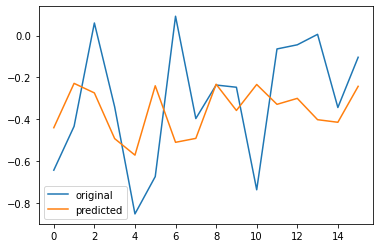

In [6]:
XGB_class(X_train,X_test,y_train,y_test,0,0,0,0,0,0,0,simple=True)

### RFE with XGBRegressor

In [7]:
def rfe_xgb(X_train, y_train,learning_rate, n_estimators, max_depth,min_child_weight, gamma, subsample, colsample_bytree, simple):
    min_features_to_select = 50
    
    #run RFE on current train subset
    if simple:
        clf = xgb.XGBRegressor()
    else:
        clf = xgb.XGBRegressor(learning_rate = learning_rate, n_estimators = int(n_estimators), max_depth = int(max_depth), 
                                min_child_weight = min_child_weight, gamma = gamma, subsample = subsample, 
                                colsample_bytree = colsample_bytree, seed = 24)

    rfecv = RFECV(estimator=clf,min_features_to_select=min_features_to_select,step=3,n_jobs=-1,scoring="r2",cv=5)
    rfecv.fit(X_train, y_train)
    
    #keep selected features + check RFE accuracy scores during running
    newX_train = X_train[X_train.columns[rfecv.support_]]
    newX_test = X_test[X_test.columns[rfecv.support_]]
    print('We kept',newX_train.shape[1],'features out of the',X_train.shape[1])

    plt.figure()
    lines = []
    for i in range(rfecv.grid_scores_.shape[1]):
        lines.append(plt.plot(rfecv.grid_scores_[:,i]))

    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (accuracy)")
    plt.legend(lines,labels = ['fold 1', 'fold 2', 'fold 3','fold 4', 'fold 5'],loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    
    return newX_train,newX_test

We kept 86 features out of the 320


C:\Users\marti\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marti\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marti\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marti\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(m

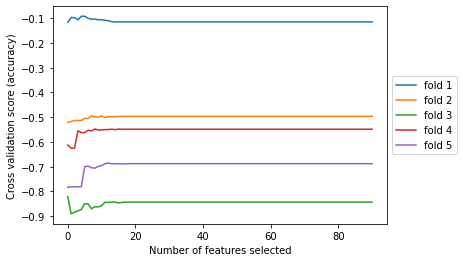

Training score:  0.9999982170612611
MSE: 0.09
R2 score = -0.09


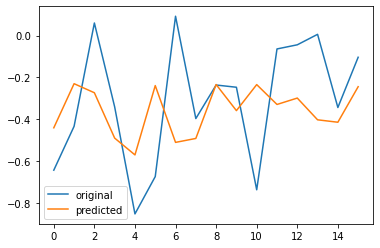

In [8]:
#test rfe then simple XGB classifier
newX_train,newX_test = rfe_xgb(X_train, y_train,0,0,0,0,0,0,0,simple=True)
XGB_class(newX_train,newX_test,y_train,y_test,0,0,0,0,0,0,0,simple=True)

## Elastic Net (with hyperparameters)

a penalized linear regression model that includes both the L1 and L2 penalties during training. Using the terminology from “The Elements of Statistical Learning,” a hyperparameter “alpha” is provided to assign how much weight is given to each of the L1 and L2 penalties

In [9]:
# # use automatically configured elastic net algorithm
# from numpy import arange
# from pandas import read_csv
# from sklearn.linear_model import ElasticNetCV
# from sklearn.model_selection import RepeatedKFold

# # define model evaluation method
# cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# # define model
# ratios = arange(0, 1, 0.01)
# alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
# model = ElasticNetCV(l1_ratio=ratios, alphas=alphas, cv=cv, n_jobs=-1)
# # fit model
# model.fit(X_train, y_train)
# # summarize chosen configuration
# print('alpha: %f' % model.alpha_)
# print('l1_ratio_: %f' % model.l1_ratio_)

Training score:  0.7855393660031036
MSE: 0.07
R2 score = 0.13


C:\Users\marti\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.844e-03, tolerance: 5.175e-04
  model = cd_fast.enet_coordinate_descent(


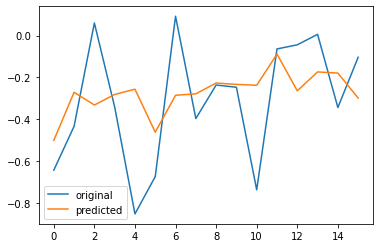

In [10]:
#hyperparameters found above:
alpha = 0.1
l1_ratio=0.24

#play around with parameters to check changes
alpha+=0.1
l1_ratio-=0.22

from sklearn.linear_model import ElasticNet

# define model
model = ElasticNet(alpha = alpha, l1_ratio=l1_ratio)
check_acc(X_train,y_train,X_test,y_test,model)

## Sparse Partial Least Square

Partial least squares regression reduces the number of variables by projecting independent variables onto latent structures. Sparse PLS combines variable selection and modeling in a one-step procedure.

### First find best number of components

C:\Users\marti\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:93: RuntimeWarning: invalid value encountered in true_divide
  y_weights = np.dot(Y.T, x_score) / np.dot(x_score.T, x_score)
C:\Users\marti\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:325: RuntimeWarning: invalid value encountered in true_divide
  x_loadings = np.dot(x_scores, Xk) / np.dot(x_scores, x_scores)
C:\Users\marti\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:334: RuntimeWarning: invalid value encountered in true_divide
  y_loadings = np.dot(x_scores, Yk) / np.dot(x_scores, x_scores)
C:\Users\marti\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\marti\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, 

C:\Users\marti\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:325: RuntimeWarning: invalid value encountered in true_divide
  x_loadings = np.dot(x_scores, Xk) / np.dot(x_scores, x_scores)
C:\Users\marti\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:334: RuntimeWarning: invalid value encountered in true_divide
  y_loadings = np.dot(x_scores, Yk) / np.dot(x_scores, x_scores)
C:\Users\marti\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\marti\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\marti\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\ma

Text(0.5, 1.0, 'hp')

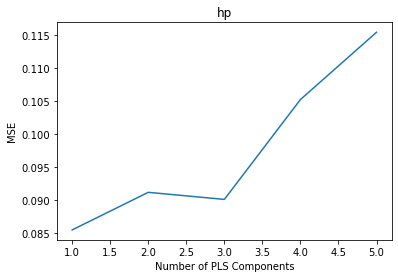

In [13]:
from sklearn.model_selection import RepeatedKFold
from sklearn import model_selection

#define cross-validation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

mse = []
n = len(X_train)

# Calculate MSE with only the intercept
score = -1*model_selection.cross_val_score(PLSRegression(n_components=1),
           np.ones((n,1)), y_train, cv=cv, scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using cross-validation, adding one component at a time
for i in np.arange(1, 6):
    pls = PLSRegression(n_components=i)
    score = -1*model_selection.cross_val_score(pls, X_train, y_train, cv=cv,
               scoring='neg_mean_squared_error').mean()
    mse.append(score)

#plot test MSE vs. number of components
plt.plot(mse)
plt.xlabel('Number of PLS Components')
plt.ylabel('MSE')
plt.title('hp')

Here, best number of components is 3

Training score:  0.5979350637860104
MSE: 0.07
R2 score = 0.12


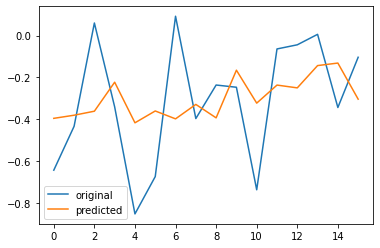

In [14]:
pls2 = PLSRegression(n_components=3)
check_acc(X_train,y_train,X_test,y_test,pls2)

## Try regression models good with short dataset

### Generalized Additive Models (GAMs)

In [30]:
from pygam import GAM, LinearGAM, s, f, te

#newX_train,newX_test = rfe_xgb(X_train, y_train,0,0,0,0,0,0,0,simple=True)

n_features = newX_train.shape[1] # number of features used in the model


lams = np.logspace(-5,5,20) * n_features
splines = 12 # number of splines we will use

# linear GAM for Regression
gam = LinearGAM(s(0,n_splines=splines)).gridsearch(newX_train.values,y_train.values,lam=lams)
gam.summary()
print(gam)

100% (20 of 20) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


AssertionError: 

## try ANN (keras)

In [75]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

#built the neural network architecture
model = Sequential()
model.add(Dense(12, input_dim=X_train.shape[1], activation='relu'))
#model.add(Dense(7, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae'])

#train the neural network on the train dataset
history = model.fit(X_train, y_train, epochs=200, validation_split=0.2)

Epoch 1/200
2/2 [==============================] - 1s 271ms/step - loss: 212.5267 - mse: 212.5267 - mae: 12.2190 - val_loss: 87.2503 - val_mse: 87.2503 - val_mae: 9.3082
Epoch 2/200
2/2 [==============================] - 0s 45ms/step - loss: 93.5649 - mse: 93.5649 - mae: 9.4691 - val_loss: 117.7587 - val_mse: 117.7587 - val_mae: 10.8297
Epoch 3/200
2/2 [==============================] - 0s 40ms/step - loss: 78.9620 - mse: 78.9620 - mae: 8.6340 - val_loss: 6.3216 - val_mse: 6.3216 - val_mae: 2.3552
Epoch 4/200
2/2 [==============================] - 0s 44ms/step - loss: 6.1545 - mse: 6.1545 - mae: 2.1128 - val_loss: 27.5431 - val_mse: 27.5431 - val_mae: 5.1579
Epoch 5/200
2/2 [==============================] - 0s 44ms/step - loss: 47.5418 - mse: 47.5418 - mae: 6.7672 - val_loss: 34.9226 - val_mse: 34.9226 - val_mae: 5.8284
Epoch 6/200
2/2 [==============================] - 0s 42ms/step - loss: 41.9680 - mse: 41.9680 - mae: 6.3195 - val_loss: 2.1257 - val_mse: 2.1257 - val_mae: 1.3305
Epo

2/2 [==============================] - 0s 48ms/step - loss: 0.9991 - mse: 0.9991 - mae: 0.8183 - val_loss: 1.6621 - val_mse: 1.6621 - val_mae: 0.9810
Epoch 52/200
2/2 [==============================] - 0s 49ms/step - loss: 1.0168 - mse: 1.0168 - mae: 0.8307 - val_loss: 1.7313 - val_mse: 1.7313 - val_mae: 1.0116
Epoch 53/200
2/2 [==============================] - 0s 61ms/step - loss: 1.0257 - mse: 1.0257 - mae: 0.8340 - val_loss: 1.6706 - val_mse: 1.6706 - val_mae: 0.9861
Epoch 54/200
2/2 [==============================] - 0s 60ms/step - loss: 1.0251 - mse: 1.0251 - mae: 0.8250 - val_loss: 1.9487 - val_mse: 1.9487 - val_mae: 1.1128
Epoch 55/200
2/2 [==============================] - 0s 67ms/step - loss: 1.0126 - mse: 1.0126 - mae: 0.8219 - val_loss: 1.7554 - val_mse: 1.7554 - val_mae: 1.0237
Epoch 56/200
2/2 [==============================] - 0s 51ms/step - loss: 0.9950 - mse: 0.9950 - mae: 0.8183 - val_loss: 1.8257 - val_mse: 1.8257 - val_mae: 1.0574
Epoch 57/200
2/2 [=================

2/2 [==============================] - 0s 39ms/step - loss: 0.8943 - mse: 0.8943 - mae: 0.7871 - val_loss: 1.4238 - val_mse: 1.4238 - val_mae: 0.9513
Epoch 152/200
2/2 [==============================] - 0s 40ms/step - loss: 0.7842 - mse: 0.7842 - mae: 0.7435 - val_loss: 0.8122 - val_mse: 0.8122 - val_mae: 0.6449
Epoch 153/200
2/2 [==============================] - 0s 40ms/step - loss: 0.9077 - mse: 0.9077 - mae: 0.7550 - val_loss: 1.4739 - val_mse: 1.4739 - val_mae: 0.9769
Epoch 154/200
2/2 [==============================] - 0s 46ms/step - loss: 0.7791 - mse: 0.7791 - mae: 0.7288 - val_loss: 2.3676 - val_mse: 2.3676 - val_mae: 1.3622
Epoch 155/200
2/2 [==============================] - 0s 45ms/step - loss: 0.9601 - mse: 0.9601 - mae: 0.8218 - val_loss: 1.2269 - val_mse: 1.2269 - val_mae: 0.8605
Epoch 156/200
2/2 [==============================] - 0s 42ms/step - loss: 0.8634 - mse: 0.8634 - mae: 0.7568 - val_loss: 0.9259 - val_mse: 0.9259 - val_mae: 0.7050
Epoch 157/200
2/2 [===========

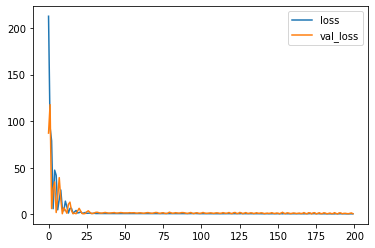

In [76]:
#plot the loss and validation loss of the dataset
history_df = pd.DataFrame(history.history)
plt.plot(history_df['loss'], label='loss')
plt.plot(history_df['val_loss'], label='val_loss')

plt.legend()

In [77]:
#evaluate the model
model.evaluate(X_test, y_test, batch_size=128)

1/1 [==============================] - 0s 42ms/step - loss: 0.6703 - mse: 0.6703 - mae: 0.7087


[0.6703020930290222, 0.6703020930290222, 0.7087392807006836]

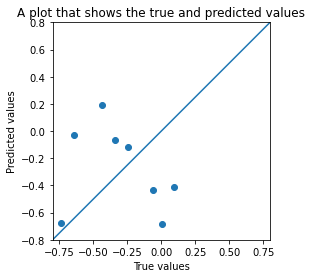

In [78]:
y_pred = model.predict(X_test).flatten()

a = plt.axes(aspect='equal')
plt.scatter(y_test, y_pred)
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('A plot that shows the true and predicted values')
plt.xlim([-0.8, 0.8])
plt.ylim([-0.8, 0.8])
plt.plot([-0.8, 0.8],[-0.8, 0.8])